# System imbalance prediction using Autoregressive Model

The exercise is about the Power market/Imbalance statement in Czech Republic.

__System Imbalance:__ When we are coming to the delivery of the electricity for one
hour, the participants (generators, consumers, traders…) of the Power Markets
might not be balanced. Meaning they might not have bought (or produce) as much
as they sold (or consume). In such case, the country would be in Imbalance (Long if
too much energy – bought too much, short if not enough energy – sold too much).
This statement is the System Imbalance. System Imbalance > 0, then the country is
long. System Imbalance < 0, the country is short.

We will work on 2021 system imbalance:
- Analyze the series: conclusions and explain with common sense the potential
reasons of these conclusions (technical and/or fundamental reasons in link
with the Power Market)
- Can we use those series to predict? If yes, what can we predict? Try it.
- Explain the choice of the model.
- Explain the results.
- What would be the next steps if you would have more time?

The analysis presented here is inspired by [Koki Noda](https://medium.com/mlearning-ai/data-science-basics-time-series-analysis-with-oil-price-data-in-python-6f0b58321659) and [Jason Brownlee](https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/).


We import the necessary modules.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import statsmodels.api as sm
from scipy import signal


c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


We import the dataset, and drop the first rows and rename the columns to get a clean data set.

In [3]:
df = pd.read_excel('ImbalancePricesVolume-2021-2022.xlsx')
df.drop(index=[0,1,2,3], inplace=True)

columns_to_rename= {}
for c in df.columns:
    columns_to_rename[c]=df.iloc[[0]][c].to_string(index=False)
df.rename(columns=columns_to_rename, inplace=True)
df.drop(index=[4],inplace=True)
df.reset_index(inplace=True, drop=True)
df.head(3)

,Day,Hour,System imbalance (MWh),Settlement price of imbalance\n(CZK/MWh),Settlement price – counter-imbalance (CZK/MWh)
0,2021-01-01 00:00:00,1,56.685,-199.39,-1
1,2021-01-01 00:00:00,2,35.897,-126.63,-1
2,2021-01-01 00:00:00,3,-62.325,2692.78,2350


Quick check if there is missing values..

In [96]:
df[df['System imbalance (MWh)'].isnull()==True].value_counts()

Series([], dtype: int64)

No missing values, thank you for this complete data set :)

We will change the index to time information for easier handling of the time serie.

In [4]:
df['datetime'] = pd.to_datetime(df['Day'], dayfirst=True) + pd.to_timedelta(df['Hour'], unit='H')
df.index = df['datetime']
df = df.drop(['Day','Hour', 'datetime'], axis=1)
display(df)

,System imbalance (MWh),Settlement price of imbalance\n(CZK/MWh),Settlement price – counter-imbalance (CZK/MWh)
datetime,,,
2021-01-01 01:00:00,56.685,-199.39,-1
2021-01-01 02:00:00,35.897,-126.63,-1
2021-01-01 03:00:00,-62.325,2692.78,2350
2021-01-01 04:00:00,-14.414,2429.27,2350
2021-01-01 05:00:00,-54.224,2648.23,2350
...,...,...,...
2021-12-31 20:00:00,66.526,-233.84,-1
2021-12-31 21:00:00,124.414,-436.44,-1
2021-12-31 22:00:00,113.625,-398.68,-1


We can now begin the exploration.

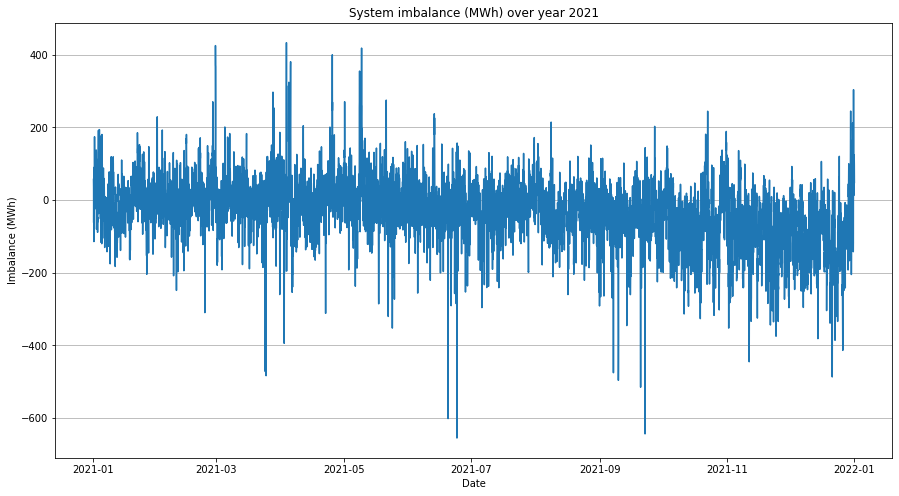

In [5]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df.index, df["System imbalance (MWh)"])
ax.grid(axis="y")
ax.set_title("System imbalance (MWh) over year 2021")
ax.set_xlabel("Date")
ax.set_ylabel("Imbalance (MWh)")
plt.show()

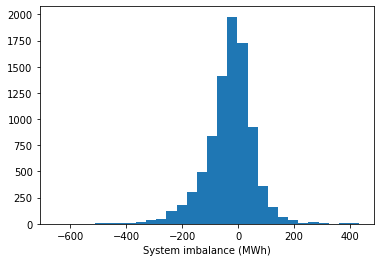

In [6]:
plt.hist(df['System imbalance (MWh)'], bins=30)
plt.xlabel("System imbalance (MWh)")
plt.show()

As expected, the system imbalance fluctuates around 0, at high frequency (due to the high sensibility of the grid), sometimes with high magnitude. We can also distinguish low frequency fluctuations that will try observe now. The histogram shows us a nice bell curve, for most part distributed around zero.
The distortion of the bell curve can be explained by the month of december, where the average system imbalance is clearly negative. We can maybe identify here an effect of __seasonality__ as winter months (November, December) show negative imbalance, due maybe to higher electric consumption due to winter weather.

We can observe the time serie for example over December using the datetime object properties: df.loc['2021-12']

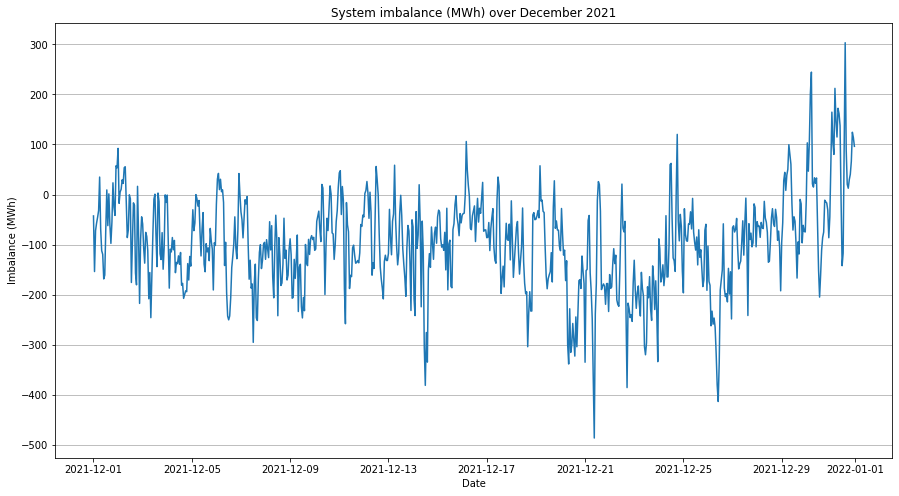

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.plot(df.loc['2021-12'].index, df.loc['2021-12']["System imbalance (MWh)"])
ax.grid(axis="y")
ax.set_title("System imbalance (MWh) over December 2021")
ax.set_xlabel("Date")
ax.set_ylabel("Imbalance (MWh)")
plt.show()

To capture broad trend, it is often useful to compute moving averages. Moving averages consist in the average of the n most recent data, rather than the average of all data. By moving the window in which the average is calculated, the time-series data can be smoothed out.

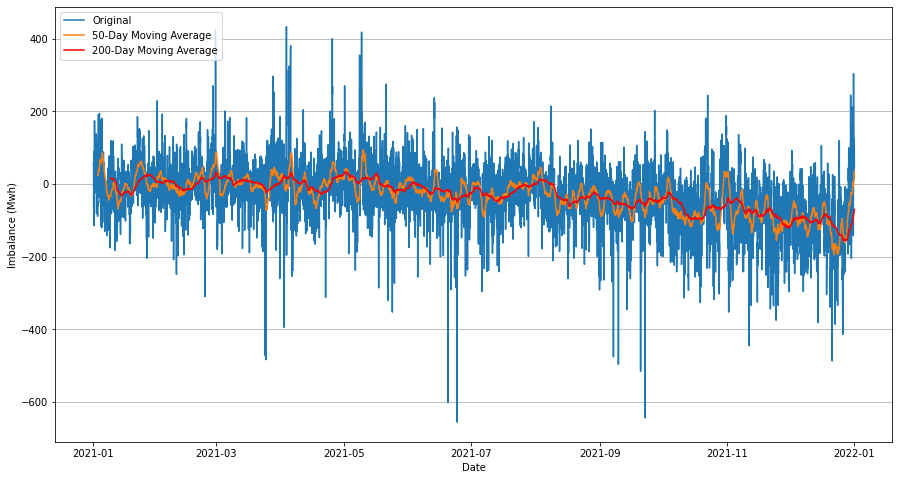

In [8]:
system_imbalance_rolling_average_50 = df['System imbalance (MWh)'].rolling(50).mean()
system_imbalance_rolling_average_200 = df['System imbalance (MWh)'].rolling(200).mean()

plt.figure(figsize=(15,8))
plt.plot(df['System imbalance (MWh)'], label="Original")
plt.plot(system_imbalance_rolling_average_50, label="50-Day Moving Average")
plt.plot(system_imbalance_rolling_average_200, label="200-Day Moving Average", color='r')
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Imbalance (Mwh)")
plt.legend(loc="upper left")
#plt.xlim((dt.datetime(2019, 1, 1), max(df.index)))
plt.show()

and over the month December 2021:

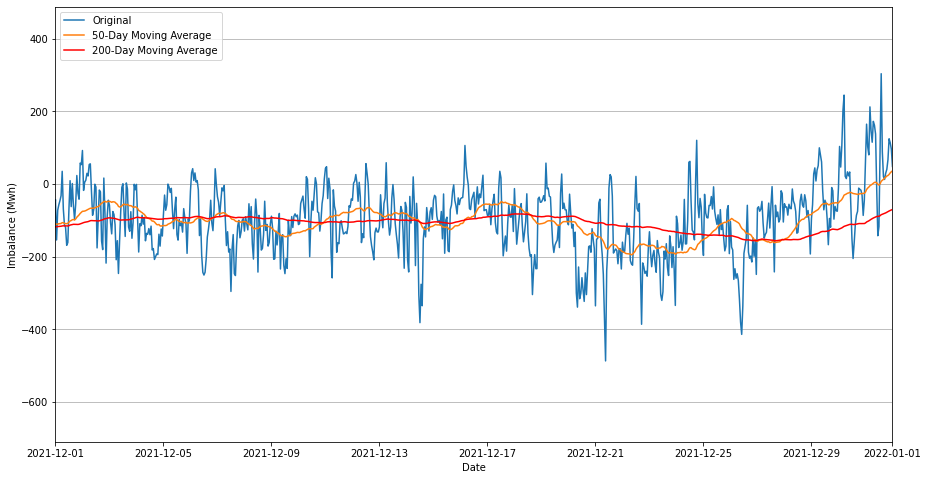

In [9]:
plt.figure(figsize=(15,8))
plt.plot(df['System imbalance (MWh)'], label="Original")
plt.plot(system_imbalance_rolling_average_50, label="50-Day Moving Average")
plt.plot(system_imbalance_rolling_average_200, label="200-Day Moving Average", color='r')
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Imbalance (Mwh)")
plt.legend(loc="upper left")
plt.xlim((dt.datetime(2021, 12, 1), dt.datetime(2022, 1, 1)))
plt.show()

We can clearly see on those two graphs, harmonical composition of the time serie. We can evaluate a period of fluctuation of approximatively 10 days for the orange curve.
Let's compute Bartlett's periodogram to see if we can capture the harmonical composition of this time serie.

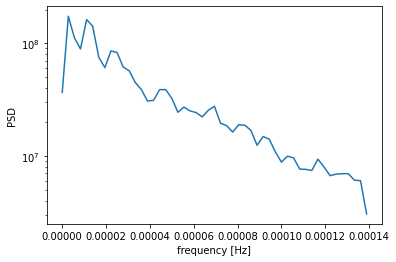

In [98]:
f, Pxx_den = signal.welch(x = df['System imbalance (MWh)'].to_list(), fs= 1/3600, nperseg=100, noverlap=0)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

I am not sure this periodogram is really usefull, as it doesn't highlight particular singular frequencies, rather a range. We will compute a periodogram on the filtered signal.

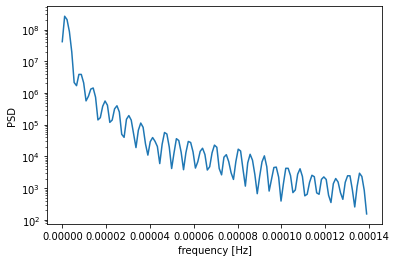

In [118]:
f, Pxx_den = signal.welch(x = system_imbalance_rolling_average_50.dropna().to_list(), fs=1/3600,nperseg=256, noverlap=0)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

We reduce the frequency range to focus on the spike at the beginning of the periodogram.

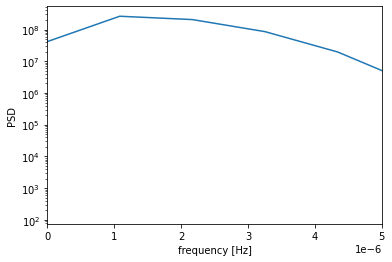

In [126]:
f, Pxx_den = signal.welch(x = system_imbalance_rolling_average_50.dropna().to_list(), fs=1/3600,nperseg=256, noverlap=0)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.xlim([0,0.000005])
plt.ylabel('PSD')
plt.show()

These periodogram shows a spike at 1e-6Hz, we means a period of approx. $T=11.6$, which comply with previous observation. The system imbalance has a 10 day main frequency, which is difficult to interpret.

We will now differenciate the time serie. This is because differencing can have tractable properties such as stationarity. Let’s actually take the difference and see how the data changes.

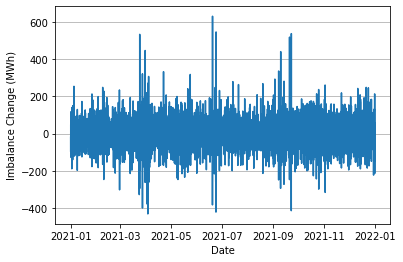

In [11]:
system_imbalance_diff = df['System imbalance (MWh)'] -  df['System imbalance (MWh)'].shift()
plt.plot(system_imbalance_diff)
plt.grid(axis="y")
plt.xlabel("Date")
plt.ylabel("Imbalance Change (MWh)")
plt.show()

The signal fluctuates up and down around zero, which was to expected also since the signal itself do it also.
Let’s check the histogram to see if the data is actually distributed around 0.

c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:836: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:837: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


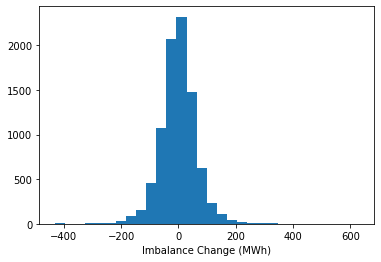

In [12]:
plt.hist(system_imbalance_diff, bins=30)
plt.xlabel("Imbalance Change (MWh)")
plt.show()

An even nicer bell curve once again, distributed around zero.

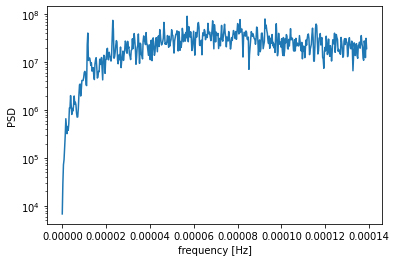

In [103]:
f, Pxx_den = signal.welch(x = system_imbalance_diff.dropna().to_list(), fs=1/3600,nperseg=1024, noverlap=0)
plt.semilogy(f, Pxx_den)
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD')
plt.show()

Here, the periodogram doesn't highlight particular frequency. It looks inverted when we compare it to the first periodograms we drew.

### Autocorrelation and partial autocorrelation

As we are dealing with time serie, it is often useful to check autocorrelation of the signal. If it is significant, we will be able to construct a model to predict future observations.\
We can check easily if there is some autocorrelation in our time serie. We first plot the observations at the previous time step (t-1) with the observation at the next time step (t+1) as a scatter plot.

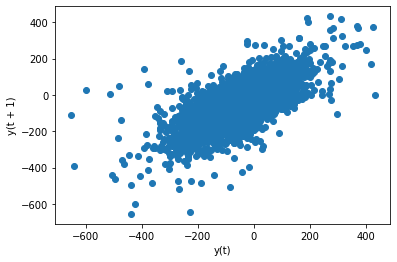

In [28]:
pd.plotting.lag_plot(df['System imbalance (MWh)'], lag=1)
plt.show()

We can see a large ball of observations along a diagonal line of the plot. It clearly shows a relationship or some correlation.

In [14]:
# autocorrelation
acf = sm.tsa.stattools.acf(df['System imbalance (MWh)'], nlags=20)
acf
# partial autocorrelation
pacf = sm.tsa.stattools.pacf(df['System imbalance (MWh)'], nlags=20, method='ols')
pacf

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


array([ 1.        ,  0.71079652, -0.01433029,  0.16736847,  0.04474506,
        0.03553322,  0.05747881,  0.05402481,  0.05869221,  0.0617173 ,
        0.02793015,  0.04056251,  0.02892687,  0.02137139,  0.01579834,
        0.02949877,  0.04104488,  0.05327927,  0.0281423 ,  0.04543357,
        0.04894954])

Let’s graph autocorrelation. The horizontal axis shows the lag and the vertical axis shows the value of the autocorrelation. 

Text(0.5, 0.98, 'Correlation on daily data')

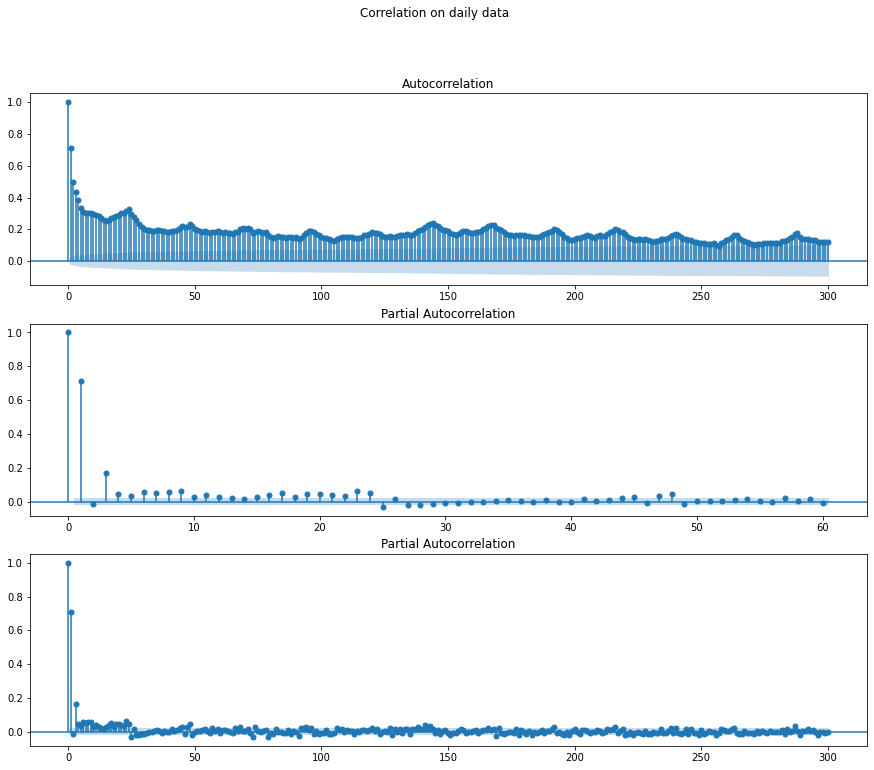

In [15]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(311)
fig = sm.graphics.tsa.plot_acf(df['System imbalance (MWh)'], lags=300, ax=ax1)
ax2 = fig.add_subplot(312)
fig = sm.graphics.tsa.plot_pacf(df['System imbalance (MWh)'], lags=60, ax=ax2, )
ax3 = fig.add_subplot(313)
fig = sm.graphics.tsa.plot_pacf(df['System imbalance (MWh)'], lags=300, ax=ax3, use_vlines='.')
fig.suptitle("Correlation on daily data")

We can see that autocorrelation is significant up to 300 hours (ie. 5 days) before the considered hour.
But when looking at partial autocorrelation,  the number of significant lags reduces around 25 hours (ie. 1 day), with strong correlation with lag 1 and 3. This suggests that System imbalance can be modelled with an autoregressive signal, of order 25, or even order 3.
Let's see what the difference serie gives us.

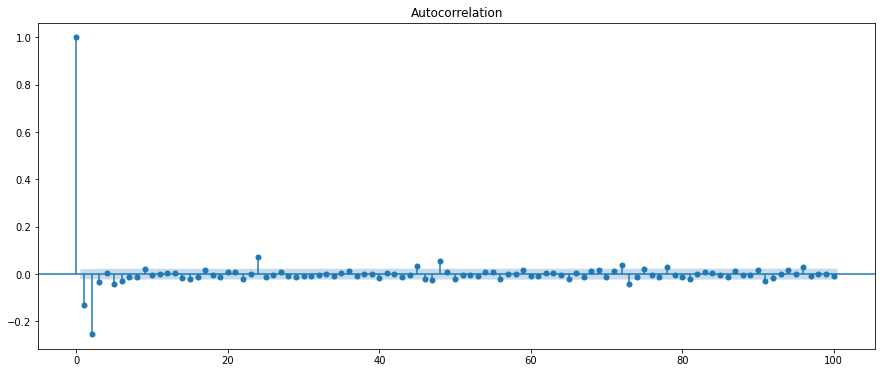

In [16]:
system_imbalance_diff
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(111)
fig = sm.graphics.tsa.plot_acf(system_imbalance_diff.dropna(), lags=100, ax=ax1)

Here, the autocorrelations are much smaller, with significant autocorrelation of order 1 and 2. We can see some higher orders, that shouldn't be used in the following model for the sake of simplicity. We will discuss this later. One interesting feature is that partial autocorrelation is negative, meaning that if the difference of system imbalance tend to react in the opposite direction than the previous hours. This result is coherent with the physical system we are studying as the grid regulators tend to compensate loss or excess of power each hour.

These results suggest that this time serie can be modelled using an autoregressive model.
We will build one using python build-in functions.
We could then train the model on year 2021 and test it on year 2022 but first, we will begin with trying to predict the signal over one day.

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


predicted=23.018994, expected=101.623000
predicted=-14.297401, expected=107.898000
predicted=-63.780956, expected=-61.615000
predicted=-34.751310, expected=-22.792000
predicted=-5.852684, expected=131.905000
predicted=-58.053442, expected=-65.909000
predicted=-78.929345, expected=-31.300000
predicted=-33.977764, expected=57.417000
predicted=-56.923044, expected=-10.715000
predicted=-67.373869, expected=-24.006000
predicted=-45.629426, expected=-150.312000
predicted=-1.415038, expected=-129.489000
predicted=56.215039, expected=25.087000
predicted=53.270300, expected=212.719000
predicted=-32.268324, expected=207.782000
predicted=-121.723119, expected=-214.633000
predicted=-51.816200, expected=-68.283000
predicted=27.880753, expected=-7.899000
predicted=17.728609, expected=17.191000
predicted=-7.051722, expected=10.589000
predicted=-6.795248, expected=26.223000
predicted=-9.068109, expected=57.888000
predicted=-28.771738, expected=-10.789000
predicted=-19.017897, expected=-17.394000
Test 

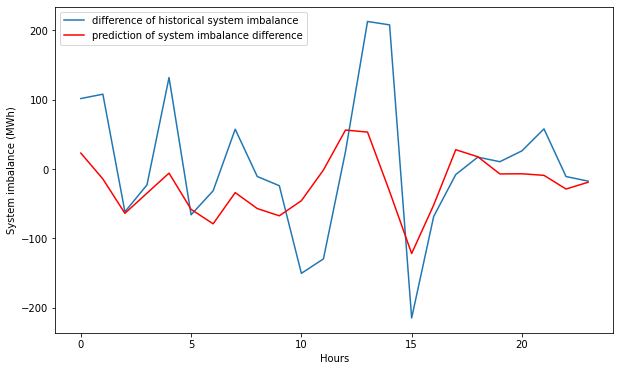

In [111]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

#split dataset
train, test = np.asarray(system_imbalance_diff['2021-01-02':'2021-12-30']), np.asarray(system_imbalance_diff['2021-12-31'])
train, test = np.reshape(train, (len(train), 1)), np.reshape(test, (len(test), 1))
# train autoregression
window = 25
model = AutoReg(train, lags=25)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.figure(figsize=(10, 6))
plt.plot(test, label= 'difference of historical system imbalance')
plt.plot(predictions, color='red', label='prediction of system imbalance difference')
plt.ylabel('System imbalance (MWh)')
plt.xlabel('Hours')
plt.legend()
plt.show()

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)


predicted=-22.802959, expected=56.668000
predicted=40.901230, expected=164.566000
predicted=98.293369, expected=102.951000
predicted=62.965045, expected=80.159000
predicted=70.636890, expected=212.064000
predicted=148.430883, expected=146.155000
predicted=61.368750, expected=114.855000
predicted=71.941932, expected=172.272000
predicted=110.749948, expected=161.557000
predicted=89.770869, expected=137.551000
predicted=86.493518, expected=-12.761000
predicted=-18.295624, expected=-142.250000
predicted=-90.327595, expected=-117.163000
predicted=-66.904191, expected=95.556000
predicted=59.933063, expected=303.338000
predicted=177.382243, expected=88.705000
predicted=32.778020, expected=20.422000
predicted=42.840565, expected=12.523000
predicted=23.976007, expected=29.714000
predicted=16.461656, expected=40.303000
predicted=25.347631, expected=66.526000
predicted=48.877929, expected=124.414000
predicted=86.457042, expected=113.625000
predicted=84.979701, expected=96.231000
Test RMSE: 88.765

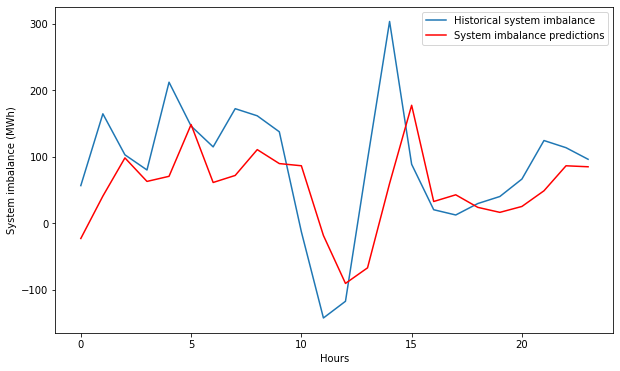

In [112]:
#split dataset
from matplotlib.pyplot import legend


train, test = np.asarray(df['System imbalance (MWh)']['2021-01-02':'2021-12-30']), np.asarray(df['System imbalance (MWh)']['2021-12-31'])
train, test = np.reshape(train, (len(train), 1)), np.reshape(test, (len(test), 1))
# train autoregression
window = 25
model = AutoReg(train, lags=25)
model_fit = model.fit()
coef = model_fit.params
# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
	length = len(history)
	lag = [history[i] for i in range(length-window,length)]
	yhat = coef[0]
	for d in range(window):
		yhat += coef[d+1] * lag[window-d-1]
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot
plt.figure(figsize=(10, 6))
plt.plot(test, label='Historical system imbalance')
plt.plot(predictions, color='red', label='System imbalance predictions')
plt.ylabel('System imbalance (MWh)')
plt.xlabel('Hours')
plt.legend()
plt.show()

We performed here predictions on the difference of system imbalance, and on system imbalance itself. The trends are the same, and the predictions give good insight of the time series variation. Interestingly, the predictions fits better on the time serie for system imbalance, with lower RSME. I have no explanation for this.

We will now plot RSME against window size, to see if high lag should really be taken into account or if we can stick to our first conclusions of Order 3 AR model.

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(self._index, pd.Int64Index):
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
c:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  return f(*args, **kwargs)
c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\deterministic.py:1451: FutureWarning: pandas.Int64Index

[]

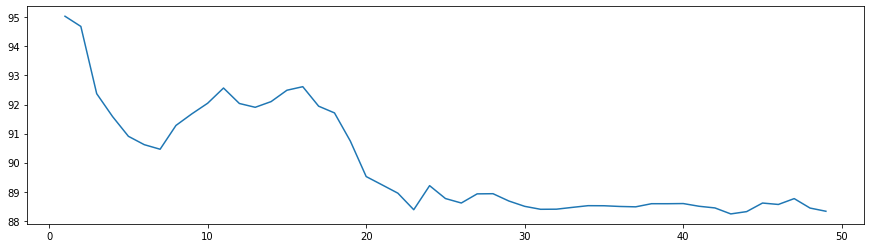

In [114]:

train, test = np.asarray(df['System imbalance (MWh)']['2021-01-02':'2021-12-30']), np.asarray(df['System imbalance (MWh)']['2021-12-31'])
train, test = np.reshape(train, (len(train), 1)), np.reshape(test, (len(test), 1))

windows = [i for i in range(1,50)]
Errors = []
for window in windows:
    # train autoregression
    model = AutoReg(train, lags=window)
    model_fit = model.fit()
    coef = model_fit.params
    # walk forward over time steps in test
    history = train[len(train)-window:]
    history = [history[i] for i in range(len(history))]
    predictions = list()
    for t in range(len(test)):
        length = len(history)
        lag = [history[i] for i in range(length-window,length)]
        yhat = coef[0]
        for d in range(window):
            yhat += coef[d+1] * lag[window-d-1]
        obs = test[t]
        predictions.append(yhat)
        history.append(obs)
    rmse = sqrt(mean_squared_error(test, predictions))
    Errors.append(rmse)
plt.figure(figsize=(15,4))
plt.plot(windows, Errors)
plt.plot()

The error is minimal and reaches a plateau from 20 hours of lag, as expected since we saw that Partial Autocorrelation was significant until 25 hours of lag. It is not useful to take more than 25 hours of lag then.
If we want the better 'precision', we will choose an AR model of order 25.
But for the sake of simplicity, and as RSME drops rapidly, we should choose an order of 5 only, or even 3, depending on performance required.

# Conclusion
We performed here a short analysis of System imbalance in the Czech Republic over year 2021.
- We tryied to capture precise harmonical composition of the time serie, direct calculation of Bartlett periodogram highlighted a core frequency of 10 days, but it is difficult to interpret as it.
- By computing the autocorrelation of the time serie, we showed that __it can be modelled by an Autoregressive (AR) random process__.
- Using Python Statsmodel build-in functions, __we computed the coefficient of the autoregressive model__ and __performed predictions over a period of a day__. It gave good results, being __able to indicate the future variations of the system imbalance__ over that time frame, but failed to capture perfectly the amplitude of variation. These predictions could certainly be used when trading electric commodities.

Further discussions:
- Refine the harmonical analysis by filtering better the signal.
- We didn't focus on particular period of the year to identify seasonal trends, but this analysis can be useful. For a deeper analysis of seasonality, several years should be compared.
- Explore new model, for instance provide more accurate prediction with distribution smoothing.
